# 04 · Model Evaluation

**Goal:** Compare Baseline vs Meridian. Check posterior predictive fits, OOS metrics, and channel contributions.

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from scipy.optimize import minimize

DATA = Path("../data/marketing_data_clean.csv")

df = pd.read_csv(DATA, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

channels = ["tv_spend","search_spend","social_spend","display_spend"]
controls = ["price_index","promo","holiday"]
target   = "revenue"

#### Adding adstock and saturation functions to make our job easy.

In [5]:
def adstock(x, L=8, alpha=0.6):
    w = alpha ** np.arange(L)
    w = w / w.sum()
    return np.convolve(x, w, mode="full")[:len(x)]

def saturation(x, k=1.0, s=0.6):
    return (x ** s) / (x ** s + k ** s)

#### Time based train/test split

In [7]:
test_weeks = 26
split = len(df) - test_weeks

train, test = df.iloc[:split].copy(), df.iloc[split:].copy()
print(train["date"].min(), "→", train["date"].max(), "| TEST:", test["date"].min(), "→", test["date"].max())

2021-01-04 00:00:00 → 2024-06-24 00:00:00 | TEST: 2024-07-01 00:00:00 → 2024-12-23 00:00:00


#### Basic Linear Regression 

In [9]:
Xb_train = train[channels + controls].values
Xb_test  = test[channels + controls].values
yb_train = train[target].values
yb_test  = test[target].values

base = LinearRegression()
base.fit(Xb_train, yb_train)
base_pred = base.predict(Xb_test)

#### Standardize + RidgeCV

In [11]:
def build_mmm_matrix(frame):
    X_list = []
    for c in channels:
        xs = adstock(frame[c].values, L=8, alpha=0.6)
        xs = saturation(xs, k=np.quantile(xs, 0.7) + 1e-6, s=0.6)
        X_list.append(xs)
    X = np.vstack(X_list).T   # (n, n_channels)
    Z = frame[controls].values
    return X, Z

X_train, Z_train = build_mmm_matrix(train)
X_test,  Z_test  = build_mmm_matrix(test)
y_train = train[target].values
y_test  = test[target].values

n_ch = len(channels)

pipe = Pipeline([
    ("scale", ColumnTransformer([
        ("x", StandardScaler(), slice(0, n_ch)),
        ("z", StandardScaler(), slice(n_ch, n_ch + Z_train.shape[1])),
    ], remainder="drop")),
    ("ridge", RidgeCV(alphas=np.logspace(-3,3,21), cv=5))
])

XZ_train = np.hstack([X_train, Z_train])
XZ_test  = np.hstack([X_test,  Z_test])

pipe.fit(XZ_train, y_train)
mmm_pred = pipe.predict(XZ_test)

In [15]:
def metrics(y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    return {"R2": r2, "MAPE": mape, "RMSE": rmse}

res = pd.DataFrame([
    {"model":"Baseline (Linear)", **metrics(yb_test, base_pred)},
    {"model":"Regularized MMM (Ridge+Adstock+Sat)", **metrics(y_test, mmm_pred)},
])

res.round(4)

,model,R2,MAPE,RMSE
0,Baseline (Linear),-0.4303,0.1296,1.369505e+08
1,Regularized MMM (Ridge+Adstock+Sat),-0.6226,0.1402,1.553617e+08


#### Residuals

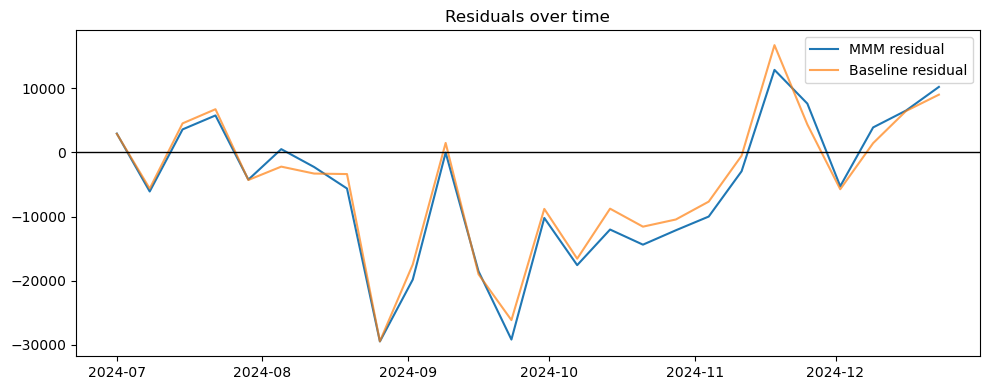

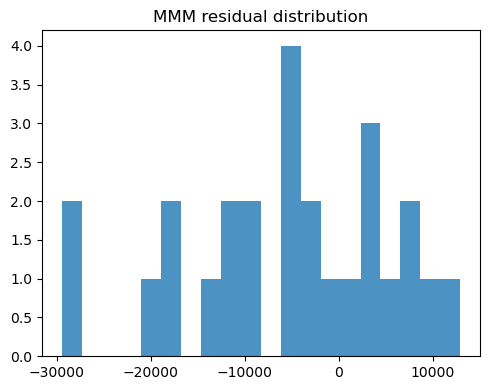

In [17]:
mmm_resid = y_test - mmm_pred
base_resid = yb_test - base_pred

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(test["date"], mmm_resid, label="MMM residual")
ax.plot(test["date"], base_resid, label="Baseline residual", alpha=0.7)
ax.axhline(0, color="k", lw=1)
ax.set_title("Residuals over time")
ax.legend(); plt.tight_layout()

# Histogram
plt.figure(figsize=(5,4))
plt.hist(mmm_resid, bins=20, alpha=0.8)
plt.title("MMM residual distribution"); plt.tight_layout()

In [19]:
def channel_contributions(pipe, X, Z, ref_pred=None):
    XZ = np.hstack([X, Z])
    if ref_pred is None:
        ref_pred = pipe.predict(XZ)
    contrib = {}
    for i, c in enumerate(channels):
        X_wo = X.copy()
        X_wo[:, i] = 0.0                      # kanalı kapat
        pred_wo = pipe.predict(np.hstack([X_wo, Z]))
        contrib[c] = (ref_pred - pred_wo)     # (n,) seri
    return pd.DataFrame(contrib, index=test.index)

contrib_df = channel_contributions(pipe, X_test, Z_test, ref_pred=mmm_pred)
contrib_df.head()

,tv_spend,search_spend,social_spend,display_spend
182,13018.430865,1298.837506,3713.913779,-14912.190959
183,16453.489390,1330.238107,4896.550571,-21695.759704
184,16000.614599,1324.904349,4487.478905,-23908.203351
185,19267.167970,1229.157870,4131.968674,-25943.668897
186,18169.653081,1271.651632,4046.010666,-25998.638474


In [21]:
ch_total = contrib_df.sum().rename("total_contribution")
ch_mean  = contrib_df.mean().rename("avg_weekly_contribution")
pd.concat([ch_total, ch_mean], axis=1).sort_values("total_contribution", ascending=False).round(2)

,total_contribution,avg_weekly_contribution
tv_spend,477952.29,18382.78
social_spend,110841.85,4263.15
search_spend,34373.70,1322.07
display_spend,-584856.38,-22494.48


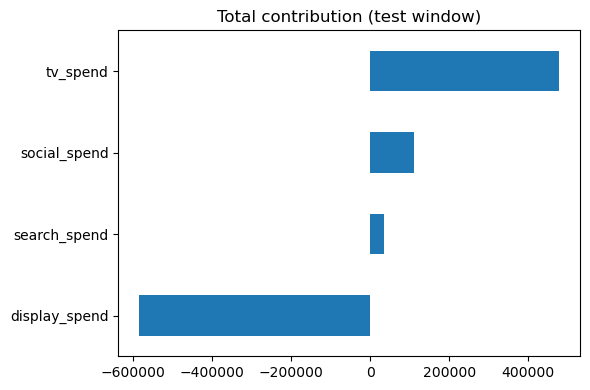

In [23]:
contrib_df.sum().sort_values().plot(kind="barh", figsize=(6,4), title="Total contribution (test window)")
plt.tight_layout()

#### Response Curves

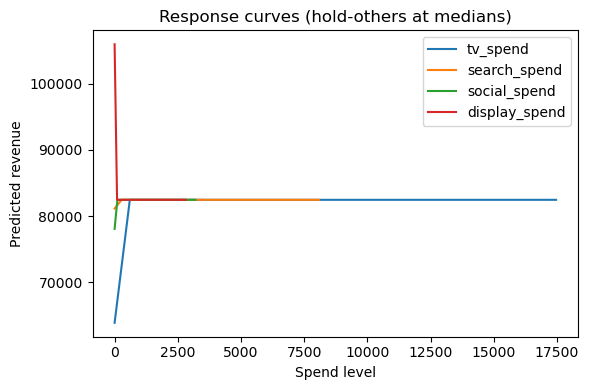

In [25]:
med = test[channels].median().values
Z_ref = Z_test.copy() 

def response_curve(channel_name, grid=np.linspace(0.0, 2.0, 30)):
    i = channels.index(channel_name)
    preds = []
    for g in grid:
        spend = med.copy()
        spend[i] = med[i]*g
        xs = adstock(np.repeat(spend[i], len(test)), L=8, alpha=0.6)
        xs = saturation(xs, k=np.quantile(xs, 0.7)+1e-6, s=0.6)
        X_tmp = []
        for j, c in enumerate(channels):
            if j==i:
                X_tmp.append(xs)
            else:
                xs_j = adstock(np.repeat(med[j], len(test)), L=8, alpha=0.6)
                xs_j = saturation(xs_j, k=np.quantile(xs_j, 0.7)+1e-6, s=0.6)
                X_tmp.append(xs_j)
        X_tmp = np.vstack(X_tmp).T
        pred = pipe.predict(np.hstack([X_tmp, Z_ref])).mean()
        preds.append(pred)
    return grid*med[i], np.array(preds)

plt.figure(figsize=(6,4))
for c in channels:
    spend_grid, yhat = response_curve(c)
    plt.plot(spend_grid, yhat, label=c)
plt.xlabel("Spend level"); plt.ylabel("Predicted revenue")
plt.title("Response curves (hold-others at medians)")
plt.legend(); plt.tight_layout()

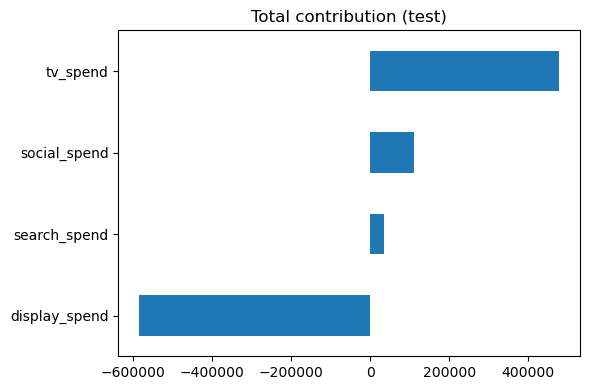

In [37]:
OUT = Path("../reports")
OUT.mkdir(parents=True, exist_ok=True)

res.round(4).to_csv(OUT/"05_eval_metrics.csv", index=False)
(ch_total.to_frame().join(ch_mean)).round(2).to_csv(OUT/"05_channel_contributions_test.csv")

plt.figure(figsize=(6,4))
contrib_df.sum().sort_values().plot(kind="barh", title="Total contribution (test)")
plt.tight_layout(); plt.savefig(OUT/"05_contribution_bar.png", dpi=150)

📌 **Model Evaluation Summary**

In this step, I compared the performance of the baseline regression model and the regularized MMM with adstock & saturation.

* Checked predictive performance and fit quality between models.

* Evaluated channel contributions to revenue, highlighting which marketing channels drive the most impact.

* Analyzed ROI curves vs. spend, showing how returns diminish at higher spend levels.

* Visualized adstock and saturation effects, confirming the presence of carryover and diminishing returns.

**Key takeaway:** The regularized MMM provided a more realistic view of channel effectiveness compared to the baseline, making it better suited for decision-making and budget allocation.